In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from lib import *
import copy
import math

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Data

In [2]:
# choose data set ("diagonal","spiral", "pie")
flag_data="pie"

In [3]:
# load data
train_X, train_Y, test_X, test_Y = load_dataset(flag_data)

# normalise data
mu=np.sum(train_X,axis=1,keepdims=True)/train_X.shape[1]
sigma=np.sqrt(np.sum((train_X-mu)**2,axis=1,keepdims=True)/train_X.shape[1])
train_X-=mu
train_X/=sigma

test_X-=mu
test_X/=sigma

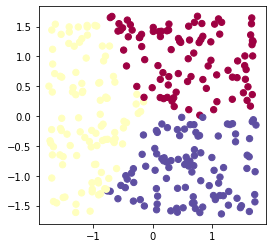

In [4]:
# training data
plt.axes().set_aspect('equal')
if(train_Y.shape[0]==1):
    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral)
else:
    plt.scatter(train_X[0, :], train_X[1, :], c=onehotToLabel(train_Y), s=40, cmap=plt.cm.Spectral);   

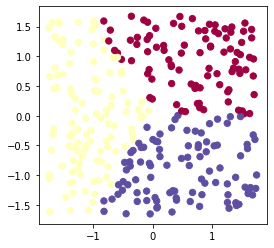

In [5]:
# test data
plt.axes().set_aspect('equal')
if(train_Y.shape[0]==1):
    plt.scatter(test_X[0, :], test_X[1, :], c=test_Y, s=40, cmap=plt.cm.Spectral)
else:
    plt.scatter(test_X[0, :], test_X[1, :], c=onehotToLabel(test_Y), s=40, cmap=plt.cm.Spectral)

In [6]:
# number of trials
train_m=train_X.shape[1]
test_m=test_X.shape[1]
# input size (= number of point's coordinates)
n_x=train_X.shape[0]
# output size (= a label for colors)
n_y=train_Y.shape[0]

In [7]:
# weights, biases, activation functions, derivatives w.r.t. them
parsWb={}
parsZAD={}
parsdWdbdA={}

# costs
costs=[]

# activation functions
# notice: dZ formula in backward_pass hardcodes choice of "sigmoid" for g3
parsg = {"g1": "relu",
         "g2": "relu",
         "g3": "sigmoid"}

# activation functions and derivatives
def relu(x):
    return np.maximum(0,x)
def reluprime(x):
    x[x>0]=1
    x[x<1]=0
    return x
def sigmoid(x):
    if(n_y==1):
        return 1/(1+np.exp(-x))
    else:
        return np.exp(x)/np.sum(np.exp(x),axis=0,keepdims=True)

# exponential decay of learning rate:
# ... initial learning rate
learning_rate0=0.01
# ... current learning rate
learning_rate=learning_rate0
# ... history
learning_rates=[]

# mini-batches
mini_batches=[]
mini_batches_size=0
mini_batches_num=0

# Adam's first/second momenta
v={}
s={}
v_corrected={}
s_corrected={}

# Hyperparameters

In [8]:
# layers' sizes
layers_dims = [n_x, 7, 5, n_y]
# number of layers
L = len(layers_dims)-1

# number of iterations
num_epochs=5000

# initialisation ("Xavier", "He")
flag_init="He"

# L2-regularization weight decay
lambd=0 #0.7

# drop-out regularisation
keep_prob=1 #0.86

# learning-rate decay (exponential decay with fixed interval scheduling)
decay_rate=1
time_interval=1000;

# desidered mini-batch size
# notice: last may be smaller
mini_batch_size=64

assert mini_batch_size<=train_m

# Adam optimisation
beta1=0.9
beta2=0.999
epsilon=1e-8

# Functions

In [9]:
# prepare mini-batches
def initialise_mini_batches(seed):    
    np.random.seed(seed)
    #np.random.seed(int(time.time()))

    global mini_batches, mini_batches_size, mini_batches_num
    
    mini_batches=[]
    mini_batches_size=[];
    mini_batches_num=0
    
    # shuffle
    perm = list(np.random.permutation(train_m))
    shuffled_X = train_X[:, perm]
    shuffled_Y = train_Y[:, perm].reshape((n_y, train_m))
    
    # partition: full-size batches
    mini_batches_num = math.floor(train_m/mini_batch_size)
    for k in range(0, mini_batches_num):
        mini_batch_X = shuffled_X[:,k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k*mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batches.append((mini_batch_X, mini_batch_Y))
        mini_batches_size.append(mini_batch_size)
    
    # partition: last batch
    if(train_m%mini_batch_size!=0):
        mini_batch_X = shuffled_X[:,mini_batches_num*mini_batch_size:]
        mini_batch_Y = shuffled_Y[:,mini_batches_num*mini_batch_size:]
        
        mini_batches.append((mini_batch_X, mini_batch_Y))
        mini_batches_size.append(train_m%mini_batch_size)
        mini_batches_num+=1

In [10]:
# initialise weights and biases
def initialiseWb():
    global parsWb
    np.random.seed(3)
    #np.random.seed(int(time.time()))
    
    parsWb={}
    
    if(flag_init=="Xavier"):
        for l in range(1,L+1):
            parsWb["W"+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(1./layers_dims[l-1])
            parsWb["b"+str(l)]=np.zeros((layers_dims[l],1))
            
    if(flag_init=="He"):
        for l in range(1,L+1):
            parsWb["W"+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2./layers_dims[l-1])
            parsWb["b"+str(l)]=np.zeros((layers_dims[l],1))

In [11]:
# initialise Adam's first/second momenta
def initialisevs():
    global parsWb,v,s,v_corrected,s_corrected
    np.random.seed(3)
    #np.random.seed(int(time.time()))
    
    v={}
    s={}
    v_corrected={}
    s_corrected={}
    
    for l in range(1,L+1):
        v["dW"+str(l)]=np.zeros((parsWb['W'+str(l)].shape[0],parsWb['W'+str(l)].shape[1]))
        v["db"+str(l)]=np.zeros((parsWb['b'+str(l)].shape[0],parsWb['b'+str(l)].shape[1]))
        s["dW"+str(l)]=np.zeros((parsWb["W"+str(l)].shape[0],parsWb["W"+str(l)].shape[1]))
        s["db"+str(l)]=np.zeros((parsWb["b"+str(l)].shape[0],parsWb["b"+str(l)].shape[1]))

In [12]:
# forward pass
def forward_pass(keep_prob):
    global parsZAD
    np.random.seed(1)
    #np.random.seed(int(time.time()))
    for l in range(1,L+1):
        # get values
        W=parsWb["W"+str(l)]
        b=parsWb["b"+str(l)]
        A=parsZAD["A"+str(l-1)]        
        # calculate values
        Z=np.dot(W,A)+b        
        parsZAD["Z"+str(l)]=Z
        A=(relu(Z) if parsg["g"+str(l)]=="relu" else sigmoid(Z))
        # drop out on hidden layers
        if l<L:
            D=np.random.rand(A.shape[0], A.shape[1])
            D=(D<keep_prob).astype(int)
            parsZAD["D"+str(l)]=D
            parsZAD["A"+str(l)]=A*D/keep_prob
        else:
            parsZAD["A"+str(l)]=A

In [13]:
# calculate cost and return it
def calculate_cost(m,Y):
    global parsZAD
    AL=parsZAD["A"+str(L)]
    
    np.seterr(divide = 'ignore', invalid='ignore')
    if(n_y==1):
        cost=np.squeeze(-np.nansum(Y*np.log(AL)+(1-Y)*np.log(1-AL))/m)
    else:
        cost=np.squeeze(-np.nansum(Y*np.log(AL))/m)
    np.seterr(divide = 'warn', invalid='warn') 
    
    for l in range(1,L+1):
        W=parsWb["W"+str(l)]
        cost+=lambd/(2.*m)*(np.sum(W**2,axis=(0,1)))
    
    return cost

In [14]:
# backward pass
def backward_pass(m,Y,keep_prob):
    global parsdWdbdA
    AL=parsZAD["A"+str(L)]
    #dAL=-np.divide(Y,AL)+np.divide(1-Y,1-AL)
    #parsdWdbdA["dA"+str(L)]=dAL
    for l in reversed(range(1,L+1)):
        # get values
        W=parsWb["W"+str(l)]
        A=parsZAD["A"+str(l-1)]
        Z=parsZAD["Z"+str(l)]
        if l==L:
            dZ=AL-Y
        else:
            dA=parsdWdbdA["dA"+str(l)]
            dZ=dA*(reluprime(Z) if parsg["g"+str(l)]=="relu" else np.nan)
        # calculate values
        parsdWdbdA["dW"+str(l)]=1./m*np.dot(dZ,A.T)+lambd/m*W
        parsdWdbdA["db"+str(l)]=1./m*np.sum(dZ,axis=1,keepdims=True)
        if(l>1):
            parsdWdbdA["dA"+str(l-1)]=np.dot(W.T,dZ)*parsZAD["D"+str(l-1)]/keep_prob
        else:
            parsdWdbdA["dA"+str(l-1)]=np.dot(W.T,dZ)
        # no need to save dZ

In [15]:
# Adam gradient descent
def gradient_descent(t):
    global parsWb, parsdWdbdA, v, s , v_corrected, s_corrected
    
    for l in range(1,L+1):
        v["dW"+str(l)]=beta1*v["dW"+str(l)]+(1-beta1)*parsdWdbdA["dW"+str(l)]
        v["db"+str(l)]=beta1*v["db"+str(l)]+(1-beta1)*parsdWdbdA["db"+str(l)]
        v_corrected["dW"+str(l)]=v["dW"+str(l)]/(1-beta1**t)
        v_corrected["db"+str(l)]=v["db"+str(l)]/(1-beta1**t)
        
        s["dW"+str(l)]=beta2*s["dW"+str(l)]+(1-beta2)*(np.power(parsdWdbdA["dW"+str(l)],2))
        s["db"+str(l)]=beta2*s["db"+str(l)]+(1-beta2)*(np.power(parsdWdbdA["db"+str(l)],2))
        s_corrected["dW"+str(l)]=s["dW" + str(l)]/(1-beta2**t)
        s_corrected["db"+str(l)]=s["db" + str(l)]/(1-beta2**t)
        
        parsWb["W"+str(l)]=parsWb["W"+str(l)]-learning_rate*v_corrected["dW"+str(l)]/(s_corrected["dW"+str(l)]**0.5+epsilon)
        parsWb["b"+str(l)]=parsWb["b"+str(l)]-learning_rate*v_corrected["db"+str(l)]/(s_corrected["db"+str(l)]**0.5+epsilon)

In [26]:
# gradient check
def gradient_check(m,X,Y,epsilon_gc):    
    global parsWb, parsZAD, parsdWdbdA
        
    np.random.seed(3)
    #np.random.seed(int(time.time()))

    parsWb={}
    for l in range(1,L+1):
        parsWb["W"+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])
        parsWb["b"+str(l)]=np.random.randn(layers_dims[l],1)
        parsWb_savedcopy=copy.deepcopy(parsWb)
    
    parsZAD={}
    parsdWdbdA={}
    
    res=True;
    
    for l in range(1,L+1):
        rows=len(parsWb_savedcopy["W"+str(l)])
        cols=len(parsWb_savedcopy["W"+str(l)][0])
        for i in range(rows):
            for j in range(cols):
                eps=np.zeros((rows,cols))
                eps[i,j]=epsilon_gc
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsWb["W"+str(l)]=parsWb["W"+str(l)]+eps
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                costPlus=calculate_cost(m,Y)
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsWb["W"+str(l)]=parsWb["W"+str(l)]-eps
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                costMinus=calculate_cost(m,Y)
                
                grad_approx=(costPlus-costMinus)/(2.*epsilon_gc)
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                
                grad_exact=parsdWdbdA["dW"+str(l)][i,j]
                
                res = res and (np.abs(grad_approx-grad_exact)<epsilon_gc)
    
    for l in range(1,L+1):
        rows=len(parsWb_savedcopy["b"+str(l)])
        cols=len(parsWb_savedcopy["b"+str(l)][0])
        for i in range(rows):
            for j in range(cols):
                eps=np.zeros((rows,cols))
                eps[i,j]=epsilon_gc
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsWb["b"+str(l)]=parsWb["b"+str(l)]+eps
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                costPlus=calculate_cost(m,Y)
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsWb["b"+str(l)]=parsWb["b"+str(l)]-eps
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                costMinus=calculate_cost(m,Y)
                
                grad_approx=(costPlus-costMinus)/(2.*epsilon_gc)
                
                parsWb=copy.deepcopy(parsWb_savedcopy)
                parsZAD={"A0": X}
                forward_pass(keep_prob)
                backward_pass(m,Y,keep_prob)
                
                grad_exact=parsdWdbdA["db"+str(l)][i,j]
                
                res = res and (np.abs(grad_approx-grad_exact)<epsilon_gc)
                
    parsWb=copy.deepcopy(parsWb_savedcopy)
    return res

In [17]:
# learning-rate decay
def learning_rate_decay(epoch_num):
    return learning_rate0/(1+decay_rate*np.floor(epoch_num/time_interval))    

In [18]:
# run training or test, depending on input variables
# calls functions above
def model(m,X,Y):
    # weights, biases, activation functions, derivatives w.r.t. them and costs
    global parsWb, parsZAD, parsdWdbdA, costs, learning_rate, learning_rates
    parsWb={}
    initialiseWb()
    costs=[]
    initialisevs()
    t=0
    learning_rate=learning_rate0
    learning_rates=[learning_rate]
    
    # run over epochs
    for i in range(num_epochs):
        
        # prepare mini-batches
        initialise_mini_batches(11+i)
        
        mini_batch_cost=0
        
        # run over mini-batches
        for j in range(mini_batches_num):
            t=t+1
            
            (mini_batch_X, mini_batch_Y) = mini_batches[j]
            
            parsZAD={"A0": mini_batch_X}
            parsdWdbdA={}
            
            forward_pass(keep_prob)
            mini_batch_cost+=calculate_cost(m,mini_batch_Y)
            backward_pass(mini_batches_size[j],mini_batch_Y,keep_prob)
            gradient_descent(t)
        
        # save cost every epoch
        costs.append(mini_batch_cost)
        
        # learning-rate decay
        learning_rate=learning_rate_decay(i)
        learning_rates.append(learning_rate)
            
        if i % 1000 == 0:
            print("Cost after epoch "+str(i)+": "+str(costs[-1]))
            print("Learning rate: "+str(learning_rate))

    # plot
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("epoch")
    plt.title("training")
    plt.show()

In [19]:
# make predictions
def predict(m,X,Y):
    global parsZAD
    parsZAD={"A0": X}
    forward_pass(1)
    Yhat=parsZAD["A"+str(L)]
    
    if(n_y==1):
        Yhat[Yhat>0.5]=1
        Yhat[Yhat<0.5]=0
        print("Accuracy: "+str(np.sum((Yhat==Y)/m)))
        return Yhat
    else:
        Y=onehotToLabel(Y)
        tmp=0
        tmp2=np.zeros(Yhat.shape[1])
        for i in range(Yhat.shape[1]):
            tmp2[i]=list(Yhat[:,i]).index(max(Yhat[:,i]))
            if(tmp2[i]==Y[i]):
                tmp=tmp+1
        print("Accuracy: "+str(tmp/m))
        Yhat=labelToOnehot(np.array(tmp2).astype(int))
        return Yhat

def predict2(X):
    global parsZAD
    parsZAD={"A0": X}
    forward_pass(1)
    Yhat=parsZAD["A"+str(L)]
    
    if(n_y==1):
        Yhat[Yhat>0.5]=1
        Yhat[Yhat<0.5]=0
        return Yhat
    else:
        tmp2=np.zeros(Yhat.shape[1])
        for i in range(Yhat.shape[1]):
            tmp2[i]=list(Yhat[:,i]).index(max(Yhat[:,i]))
        Yhat=tmp2
        return Yhat

# Main functions

In [27]:
# gradient check
gradient_check(train_m,train_X,train_Y,1e-6)

True

Cost after epoch 0: 1.237193750296384
Learning rate: 0.01
Cost after epoch 1000: 0.0011279534368137574
Learning rate: 0.005
Cost after epoch 2000: 0.0004146977288022106
Learning rate: 0.0033333333333333335
Cost after epoch 3000: 0.0002057347675345505
Learning rate: 0.0025
Cost after epoch 4000: 5.5591980536157074e-05
Learning rate: 0.002


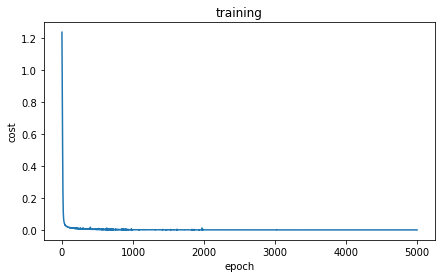

In [21]:
# learning on training points
model(train_m,train_X,train_Y)

In [22]:
# make predictions on training images
train_Yhat=predict(train_m,train_X,train_Y)

Accuracy: 1.0


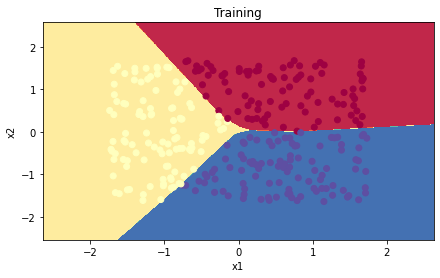

In [23]:
plt.title("Training")
axes = plt.gca()
axes.set_xlim([train_X[0,:].min()-0.9,train_X[0,:].max()+0.9])
axes.set_ylim([train_X[1,:].min()-0.9,train_X[1,:].max()+0.9])
if(n_y==1):
    plot_decision_boundary(lambda x: predict2(x.T), train_X, train_Y)
else:
    plot_decision_boundary(lambda x: predict2(x.T), train_X, onehotToLabel(train_Y))

In [24]:
# make predictions on test images
test_Yhat=predict(test_m,test_X,test_Y)

Accuracy: 0.9833333333333333


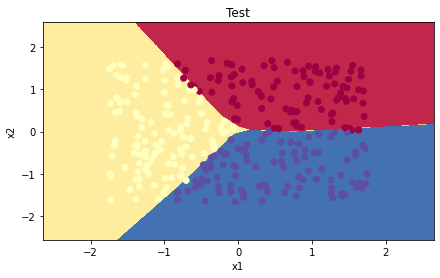

In [25]:
plt.title("Test")
axes = plt.gca()
axes.set_xlim([test_X[0,:].min()-0.9,test_X[0,:].max()+0.9])
axes.set_ylim([test_X[1,:].min()-0.9,test_X[1,:].max()+0.9])
if(n_y==1):
    plot_decision_boundary(lambda x: predict2(x.T), test_X, test_Y)
else:
    plot_decision_boundary(lambda x: predict2(x.T), test_X, onehotToLabel(test_Y))